In [2]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:90%;}
div.CodeMirror {font-family:Consolas; font-size:18pt;}
div.output {font-size:19pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:19pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
span.toc-item-num{display:none;}
div.text_cell_render ul li{font-size:16pt;padding:5px;}
div.CodeMirror-lines > div {padding-left:10px;}
table.dataframe{font-size:19px;}
</style>
"""))

# 1. LeNet: 최초의 CNN
```
<img src='image/LeNet.png' alt='LeNet' width="300">
```
![LeNet](image/LeNet.png)
FC(120): 120개 출력층인 뉴런을 가진 Fully connected 레이어 

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, AvgPool2D, Flatten, Dense
                                            # AveragePooling2D 동일
from tensorflow.keras.callbacks import EarlyStopping, Callback
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

In [3]:
class CustomHistory(Callback): # on_epoch_end()는 각 에포크 종료시 호출
    def __init__(self, times=5):  # 생성자 함수
        self.epoch = 0
        self.times = times
    def on_epoch_end(self, batch, logs={}):
        self.epoch += 1
        if self.epoch%self.times == 0:
            print('epoch:{}, loss:{}, acc:{}, val_loss:{}, val_accuracy:{}'.\
                 format(self.epoch,
                        logs.get('loss'),
                        logs.get('accuracy'),
                        logs.get('val_loss'),
                        logs.get('val_accuracy')
                       ))



In [4]:
# 출력사이즈 = (입력사이즈 - 커널사이즈)/스트라이드 +1
class LeNet:
    @staticmethod
    def build(input_shape=(32,32,1), activation='relu'):
        model = Sequential()
        model.add(Input(shape=input_shape))
        model.add(Conv2D(6, # 커널갯수
                         kernel_size=(5,5),
                        activation=activation,
                        kernel_initializer='he_normal',
                        padding='valid'))
        model.add(AvgPool2D(pool_size=(2,2),
                           #strides=2,
                            strides=(2,2)
                           ))
        model.add(Conv2D(16,kernel_size=(5,5),
                        activation=activation,
                        kernel_initializer='he_normal'))
        model.add(AvgPool2D(pool_size=(2,2),strides=2))
        model.add(Flatten())
        model.add(Dense(120,activation='relu', kernel_initializer='he_normal'))
        model.add(Dense(84,activation='relu', kernel_initializer='he_normal'))
        model.add(Dense(10,activation='softmax')) # 출력층
        return model

In [5]:
class LeNet:
    @staticmethod
    def build(input_shape=(32,32,1),activation='relu'):
        model= Sequential([
            Input(shape=input_shape),
            Conv2D(6, # 커널갯수
                         kernel_size=(5,5),
                        activation=activation,
                        kernel_initializer='he_normal',
                        padding='valid'),
            AvgPool2D(pool_size=(2,2),
                           #strides=2,
                            strides=(2,2)
                           ),
            Conv2D(16, # 커널갯수
                        kernel_size=(5,5),
                        activation=activation,
                        kernel_initializer='he_normal',
                        padding='valid'),
            AvgPool2D(pool_size=(2,2),strides=2),
            Flatten(),
            Dense(120,activation='relu', kernel_initializer='he_normal'),
            Dense(84,activation='relu', kernel_initializer='he_normal'),
            Dense(10,activation='softmax'),
                                  ])
        return model

In [6]:
model = LeNet.build(input_shape=(28,28,1), activation='relu')
print(model.summary()) # 156 = 5*5*6+6
                       # 5*5*16*6+16= 2416
    #input 28 - 5*5사이즈 + strides 1 = 24 
    #flatten * dense + dense= 30840
    #dense_1 * dense + dense_1 = 10164
    
    

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 12, 12, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 4, 4, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 120)               3

In [7]:
# 1. 데이터
from tensorflow.keras.datasets import mnist
(X_train,y_train), (X_test,y_test) = mnist.load_data()
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
X_train = X_train.reshape(-1,28,28,1).astype('float32')
X_test = X_test.reshape(-1,28,28,1).astype('float32')
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


In [8]:
# 2. 모델생성
model =LeNet.build(input_shape= (28,28,1), activation='relu')
# 3. 학습설정
model.compile(loss='sparse_categorical_crossentropy', # 원핫인코딩을 안하고 분류분석을 하는경우)
              optimizer= 'adam',
              metrics=['accuracy'])
# 4. 학습
customHistory= CustomHistory(3)
earlystopping = EarlyStopping(patience=10)
hist = model.fit(X_train, y_train,
                validation_split=0.2,
                 epochs=50,
                 callbacks=[customHistory,earlystopping],
                 verbose=0)

epoch:3, loss:0.12864917516708374, acc:0.9667500257492065, val_loss:0.13693764805793762, val_accuracy:0.9649166464805603
epoch:6, loss:0.06636416912078857, acc:0.9804375171661377, val_loss:0.10214439779520035, val_accuracy:0.9734166860580444
epoch:9, loss:0.043260347098112106, acc:0.9871249794960022, val_loss:0.09039922803640366, val_accuracy:0.9776666760444641
epoch:12, loss:0.030253127217292786, acc:0.9912291765213013, val_loss:0.07631182670593262, val_accuracy:0.9831666946411133
epoch:15, loss:0.020710458979010582, acc:0.9939166903495789, val_loss:0.0806790292263031, val_accuracy:0.9848333597183228
epoch:18, loss:0.017836812883615494, acc:0.9948541522026062, val_loss:0.08118350803852081, val_accuracy:0.9849166870117188


In [9]:
loss, accuracy = model.evaluate(X_test,y_test)
print("accuracy:{:.2f}%".format(accuracy*100))

313/313 [==============================] - 1s 4ms/step - loss: 0.0887 - accuracy: 0.9848
accuracy:98.48%


In [10]:
yhat= model.predict(X_test).argmax(axis=1)
display(pd.crosstab(y_test,yhat)) # 결과가 데이터 프레임
#print(confusion_matrix(y_test,yhat))  #결과가 넘파이 배열
cnt = 0
for y,h in zip(y_test,yhat):
    if y!=h:
        cnt+=1
print('예측이 틀린갯수:', cnt)

313/313 [==============================] - 1s 2ms/step


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,974,0,0,0,0,0,1,1,1,3
1,1,1125,1,1,1,0,1,5,0,0
2,4,1,1017,2,0,0,0,5,2,1
3,1,0,1,995,0,7,0,0,4,2
4,0,2,1,0,958,0,5,3,2,11
5,2,0,1,5,0,861,5,1,11,6
6,5,4,0,1,2,1,942,0,3,0
7,0,3,5,1,0,0,0,1016,1,2
8,2,0,1,0,1,0,0,2,965,3


예측이 틀린갯수: 152


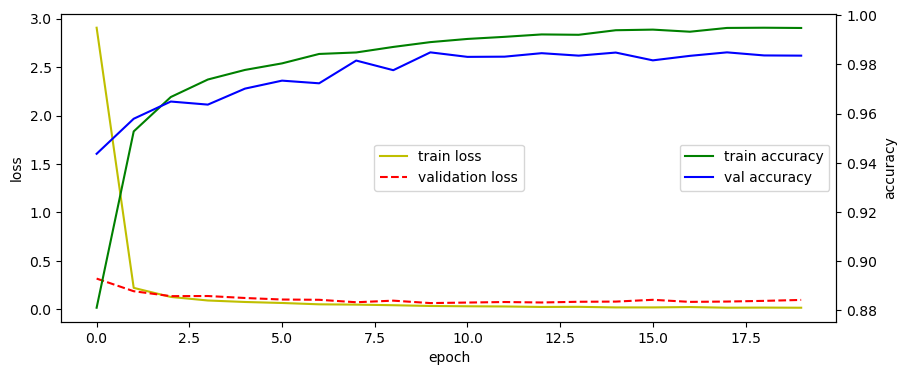

In [11]:
# 학습과정 중의 loss와 accuracy
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,4))
loss_ax.plot(hist.history['loss'],'y',label='train loss')
loss_ax.plot(hist.history['val_loss'],'r--',label='validation loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'],'g',label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'],'b',label='val accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center')
acc_ax.legend(loc='center right')
plt.show()

i =  2996
cnt =  70


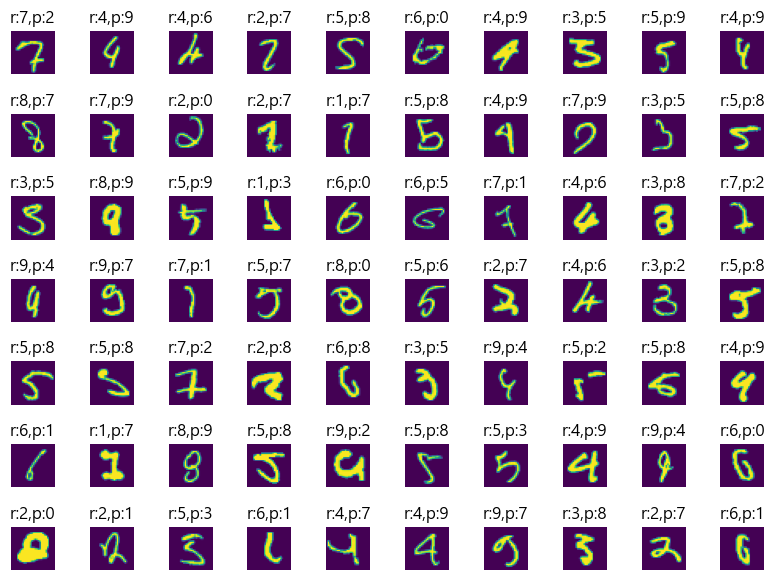

In [12]:
plt_row = 7
plt_col = 10
plt.rcParams['figure.figsize'] = (plt_col, plt_row)
plt.rc('font', family='Malgun Gothic') # 윈도우즈
fig, axarr = plt.subplots(nrows=plt_row, ncols=plt_col)
plt.subplots_adjust(hspace=0.9, wspace=0.2)

i = 0 # yhat , y_test 를 엑세스 할 index
cnt = 0 # 출력할 횟수
while (cnt<plt_row*plt_col) & (i < len(y_test)):
    # 예측한 결과가 틀렸을 경우만 imshow(X_test[i]), 실제값과 예측치를 title에 출력
    if yhat[i]==y_test[i]:
        i += 1
        continue
    # 예측한 값과 실제값이 다른 경우
    sub_plot = axarr[cnt//plt_col, cnt%plt_col]
    sub_plot.imshow(X_test[i].reshape(28,28))
    title = 'r:{},p:{}'.format(y_test[i],yhat[i])
    sub_plot.set_title(title)
    sub_plot.axis('off')
    i += 1
    cnt += 1
print('i = ', i)
print('cnt = ', cnt)

# 2. AlexNet
- GPU를 사용하여 실현 가능한 모델. 알렉스와 제프리 힌튼이 공동 설계한 CNN아키텍쳐이름


In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization # 배치 정규화
import matplotlib.pyplot as plt

In [14]:
import tensorflow as tf
print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.10.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
# 출력사이즈 = (입력사이즈 - 커널사이즈) / 스트라이드 + 1
class AlexNet:
    @staticmethod
    def build(input_shape=(224, 224, 3), activation='relu', class_num=1000):
        model = Sequential([
            Input(shape=input_shape),
            Conv2D(96,  # 커널갯수
                   kernel_size=(11, 11),
                   strides=(4, 4),
                   activation=activation,
                   padding='same'),  # 두 번째 MaxPooling 오류 방지를 위함
            MaxPooling2D(pool_size=(3, 3), strides=2),
            BatchNormalization(),  # 배치졍규화
            Conv2D(256, kernel_size=(5, 5), activation=activation, padding='same'),
            MaxPooling2D(pool_size=(3, 3), strides=2),
            BatchNormalization(),
            Conv2D(384, kernel_size=(3, 3), activation=activation, padding='same'),
            Conv2D(384, kernel_size=(3, 3), activation=activation, padding='same'),
            Conv2D(256, kernel_size=(3, 3), activation=activation, padding='same'),
            # AlexNet은 224*224 이미지에 맞춰서 3*3 pooling이 되나,
            # cifar 32*32 이미지에서는 아래의 MaxPooling단계는 생략
            # MaxPooling2D(pool_size=(3, 3), strides=2),
            Flatten(),            
            Dense(units=4096, activation=activation),
            Dropout(0.5),
            Dense(units=4096, activation=activation),
            Dropout(0.5),
            Dense(units=class_num, activation='softmax')  # 출력층
        ])
        return model

In [16]:
model = AlexNet.build(input_shape=(32,32,3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 8, 8, 96)          34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 96)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 3, 3, 96)         384       
 ormalization)                                                   
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 256)         614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 256)        0         
 2D)                                                             
                                                      

In [17]:
# 1. 데이터
from tensorflow.keras.datasets import cifar10
(X_train,y_train),(X_test, y_test) = cifar10.load_data()
X_train.shape,y_train.shape,X_test,y_test.shape

((50000, 32, 32, 3),
 (50000, 1),
 array([[[[158, 112,  49],
          [159, 111,  47],
          [165, 116,  51],
          ...,
          [137,  95,  36],
          [126,  91,  36],
          [116,  85,  33]],
 
         [[152, 112,  51],
          [151, 110,  40],
          [159, 114,  45],
          ...,
          [136,  95,  31],
          [125,  91,  32],
          [119,  88,  34]],
 
         [[151, 110,  47],
          [151, 109,  33],
          [158, 111,  36],
          ...,
          [139,  98,  34],
          [130,  95,  34],
          [120,  89,  33]],
 
         ...,
 
         [[ 68, 124, 177],
          [ 42, 100, 148],
          [ 31,  88, 137],
          ...,
          [ 38,  97, 146],
          [ 13,  64, 108],
          [ 40,  85, 127]],
 
         [[ 61, 116, 168],
          [ 49, 102, 148],
          [ 35,  85, 132],
          ...,
          [ 26,  82, 130],
          [ 29,  82, 126],
          [ 20,  64, 107]],
 
         [[ 54, 107, 160],
          [ 56, 105, 14

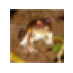

In [18]:
plt.figure(figsize=(0.7,0.7))
plt.imshow(X_train[0])
plt.axis('off')
plt.show()

In [19]:
X_train[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

In [20]:
# 스케일 조정
X_train = X_train/255.0
X_test = X_test/255.0
X_train.shape,y_train.shape,X_test,y_test.shape

((50000, 32, 32, 3),
 (50000, 1),
 array([[[[0.61960784, 0.43921569, 0.19215686],
          [0.62352941, 0.43529412, 0.18431373],
          [0.64705882, 0.45490196, 0.2       ],
          ...,
          [0.5372549 , 0.37254902, 0.14117647],
          [0.49411765, 0.35686275, 0.14117647],
          [0.45490196, 0.33333333, 0.12941176]],
 
         [[0.59607843, 0.43921569, 0.2       ],
          [0.59215686, 0.43137255, 0.15686275],
          [0.62352941, 0.44705882, 0.17647059],
          ...,
          [0.53333333, 0.37254902, 0.12156863],
          [0.49019608, 0.35686275, 0.1254902 ],
          [0.46666667, 0.34509804, 0.13333333]],
 
         [[0.59215686, 0.43137255, 0.18431373],
          [0.59215686, 0.42745098, 0.12941176],
          [0.61960784, 0.43529412, 0.14117647],
          ...,
          [0.54509804, 0.38431373, 0.13333333],
          [0.50980392, 0.37254902, 0.13333333],
          [0.47058824, 0.34901961, 0.12941176]],
 
         ...,
 
         [[0.26666667, 0.4862745

In [21]:
# 2. 모델
# model = AlexNet.build(input_shape=(32,32,3),class_num=10) 학습시간 단축을 위해 아래 사용
model = Sequential([
        Input(shape=(32,32,3)),
        Conv2D(96,  # 커널갯수
               kernel_size=(11, 11),
               strides=(4, 4),
               activation='relu',
               padding='same'),  # => 파라미터수 = 11*11*96*3(채널수)+96(출력수)=34944
        MaxPooling2D(pool_size=(3, 3), strides=2),
        BatchNormalization(),  # 배치졍규화
        Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'), #=>96*3*3*384+384
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'), #=>96*3*3*384+384
        # AlexNet은 224*224 이미지에 맞춰서 3*3 pooling이 되나,
        # cifar 32*32 이미지에서는 아래의 MaxPooling단계는 생략
        # MaxPooling2D(pool_size=(3, 3), strides=2),
        Flatten(),            
        Dense(units=1024, activation='relu'),
        Dropout(0.5),
        Dense(units=512, activation='relu'),
        Dropout(0.5),
        Dense(units=10, activation='softmax')  # 출력층
    ])
model.summary()  

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 8, 8, 96)          34944     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 96)         0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 3, 3, 96)         384       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 3, 3, 384)         332160    
                                                                 
 conv2d_11 (Conv2D)          (None, 3, 3, 256)         884992    
                                                                 
 flatten_3 (Flatten)         (None, 2304)             

In [22]:
# 3. 학습설정
model.compile(loss='sparse_categorical_crossentropy', # 원핫인코딩 안했을때 사용
             optimizer='adam',
             metrics=['accuracy'])
hist = model.fit(X_train, y_train,
                epochs=20,
                validation_data=[X_test, y_test])

Epoch 1/20
1563/1563 [==============================] - 18s 11ms/step - loss: 1.6572 - accuracy: 0.4032 - val_loss: 1.5847 - val_accuracy: 0.4361
Epoch 2/20
1563/1563 [==============================] - 16s 10ms/step - loss: 1.3962 - accuracy: 0.5121 - val_loss: 1.5911 - val_accuracy: 0.4630
Epoch 3/20
1563/1563 [==============================] - 16s 10ms/step - loss: 1.2681 - accuracy: 0.5604 - val_loss: 1.4497 - val_accuracy: 0.5034
Epoch 4/20
1563/1563 [==============================] - 16s 10ms/step - loss: 1.1730 - accuracy: 0.5969 - val_loss: 1.2907 - val_accuracy: 0.5571
Epoch 5/20
1563/1563 [==============================] - 16s 10ms/step - loss: 1.0956 - accuracy: 0.6206 - val_loss: 1.5547 - val_accuracy: 0.5082
Epoch 6/20
1563/1563 [==============================] - 16s 10ms/step - loss: 1.0273 - accuracy: 0.6466 - val_loss: 1.3097 - val_accuracy: 0.5570
Epoch 7/20
1563/1563 [==============================] - 16s 10ms/step - loss: 0.9597 - accuracy: 0.6649 - val_loss: 1.2675 -

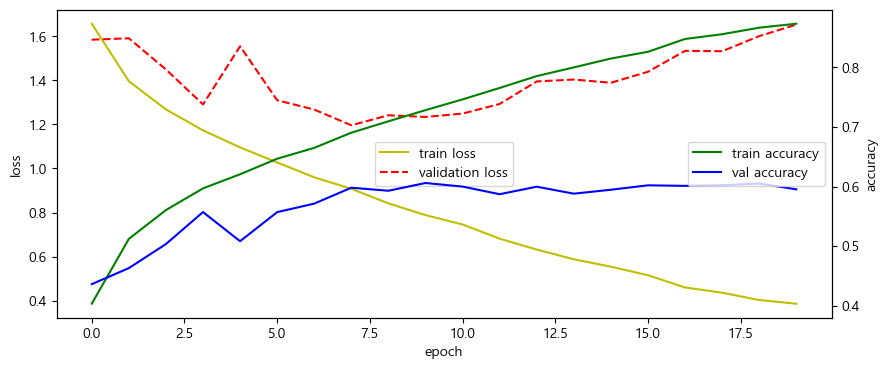

In [23]:
# 학습과정 중의 loss와 accuracy
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,4))
loss_ax.plot(hist.history['loss'],'y',label='train loss')
loss_ax.plot(hist.history['val_loss'],'r--',label='validation loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'],'g',label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'],'b',label='val accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center')
acc_ax.legend(loc='center right')
plt.show()

In [27]:
# 5. 모델평가
# airplane(0), automobile(1), bird(2), cat(3), deer(4), dog(5), frog(6), horse(7), ship(8), truck(9)
#y_test.reshape(-1)# 실제값을 1차원으로 변경한값
y_hat = np.argmax(model.predict(X_test),axis=1)
ctab = pd.crosstab(y_test.reshape(-1),y_hat)
ctab.columns=['airplane(0)', 'automobile(1)', 'bird(2)', 'cat(3)', 'deer(4)', 'dog(5)', 'frog(6)', 'horse(7)', 'ship(8)', 'truck(9)']
ctab.columns.name='predict'
ctab.index=['airplane(0)', 'automobile(1)', 'bird(2)', 'cat(3)', 'deer(4)', 'dog(5)', 'frog(6)', 'horse(7)', 'ship(8)', 'truck(9)']
ctab.index.name='real'
ctab

313/313 [==============================] - 1s 3ms/step


predict,airplane(0),automobile(1),bird(2),cat(3),deer(4),dog(5),frog(6),horse(7),ship(8),truck(9)
real,,,,,,,,,,
airplane(0),710,22,31,27,44,13,7,14,85,47
automobile(1),39,664,9,25,8,15,7,15,63,155
bird(2),93,11,422,103,145,66,49,61,21,29
cat(3),33,20,44,431,85,202,50,61,28,46
deer(4),35,13,71,97,554,55,19,114,26,16
dog(5),15,12,58,206,45,522,24,87,9,22
frog(6),13,16,56,108,96,53,566,29,22,41
horse(7),24,8,35,50,53,88,4,680,10,48
ship(8),113,40,7,25,19,9,4,6,723,54


array([3], dtype=uint8)

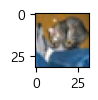

In [31]:
plt.figure(figsize=(0.7,0.7))
plt.imshow(X_test[0])
y_test[0]

In [35]:
pred = model.predict(X_test[1].reshape(-1,32,32,3)).argmax(axis=1)
pred,y_test[1]


1/1 [==============================] - 0s 22ms/step


(array([8], dtype=int64), array([8], dtype=uint8))

# 3. VGG
- 옥스포드 대 VGG팀에서 구현한 CNN( 컨볼루션과 맥스폴링 19개층)
- VGG-19 구현

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19

In [2]:
class Vgg19:
    @staticmethod
    def build(input_shape = (224, 224, 3), activation = 'relu', class_num = 1000):
        model = Sequential([
            Input(shape = input_shape),
            Conv2D(64, (3, 3), activation = activation, padding = 'same'),
            Conv2D(64, (3, 3), activation = activation, padding = 'same'),
            MaxPooling2D(),
            Conv2D(128, (3, 3), activation = activation, padding = 'same'),
            Conv2D(128, (3, 3), activation = activation, padding = 'same'),
            MaxPooling2D(),
            Conv2D(256, (3,3), activation = activation, padding = 'same'),
            Conv2D(256, (3,3), activation = activation, padding = 'same'),
            Conv2D(256, (3,3), activation = activation, padding = 'same'),
            Conv2D(256, (3,3), activation = activation, padding = 'same'),
            MaxPooling2D(),
            Conv2D(512, (3,3), activation = activation, padding = 'same'),
            Conv2D(512, (3,3), activation = activation, padding = 'same'),
            Conv2D(512, (3,3), activation = activation, padding = 'same'),
            Conv2D(512, (3,3), activation = activation, padding = 'same'),
            MaxPooling2D(),
            Conv2D(512, (3,3), activation = activation, padding = 'same'),
            Conv2D(512, (3,3), activation = activation, padding = 'same'),
            Conv2D(512, (3,3), activation = activation, padding = 'same'),
            Conv2D(512, (3,3), activation = activation, padding = 'same'),
            MaxPooling2D(),
            Flatten(),
            Dense(4096, activation = 'relu'),
            Dense(4096, activation = 'relu'),
            Dense(1000, activation = 'softmax')
        ])
        return model

In [3]:
model= Vgg19.build()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [4]:
vggModel = VGG19() # 학습을 하지 않고 imageNet으로 학습이 끝난 model*weights 내려받아 가중치만 사용
weights = vggModel.get_weights()
model.set_weights(weights=weights) # 학습이 끝난 가중치를 model에 이식
# 추가적인 재학습도 가능함

In [5]:
import cv2

In [ ]:
# 방법1
img_cv2= cv2.imread('data/sample.jpg',
                    cv2.IMREAD_COLOR,#BGR포맷, 알파채널 무시
                    #cv2.IMREAD_UNCHANGED, # 투명도까지 그대로 읽음
                    #cv2.IMREAD_GRAYSCALE, # 흑백으로 읽음
                   )
img_cv2 = cv2.resize(img_cv2,dsize=(224,224),
                    interpolation=cv2.INTER_NEAREST) # 보간법을 이용하여 사이즈 보정
cv2.imshow('sample',img_cv2)
cv2.waitKey(0) # 키보드입력을 기다림. 이미지가 화면에 표시된 상태를 유지
cv2.destroyAllWindows()# openCV를 통해 생성된 모든 창을 닫음
img_cv2.shape

In [ ]:
plt.figure(figsize=(2,2))
# BGR 포맷인 img_cv2를 RGB포맷으로
img_cv2_rgb = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
plt.imshow(img_cv2_rgb)
plt.show()
type(img_cv2_rgb)

In [6]:
# 방법 2
from tensorflow.keras.preprocessing import image
img = image.load_img('data/sample.jpg',target_size=(224,224))
print(type(img))
img_data= image.img_to_array(img)
print('읽어온 img_data의 type:', type(img_data),',img_data의 shape:', img_data.shape)


<class 'PIL.Image.Image'>
읽어온 img_data의 type: <class 'numpy.ndarray'> ,img_data의 shape: (224, 224, 3)


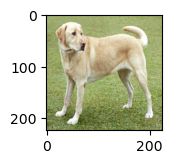

In [29]:
plt.figure(figsize=(1.5,1.5))
plt.imshow(img)
plt.show()

(numpy.ndarray, (224, 224, 3))

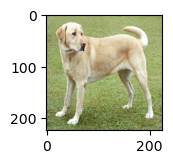

In [35]:
# 방법3
img_data1=plt.imread('data/sample.jpg')
img_data1=cv2.resize(img_data1,dsize=(224,224),
                    interpolation=cv2.INTER_NEAREST)
plt.figure(figsize=(1.5,1.5))
plt.imshow(img_data1)
type(img_data1),img_data1.shape


In [8]:
# 차원변경( 224,224,3)=> (1,224,224,3)
import numpy as np
a = np.array([1,2,3])
# a의 shape(3,) => (1,3) ; newaxis를 이용한 축추가, reshape을 이용한 shape
print('a 배열의 축추가(3행1열) :\n',a[:,np.newaxis])
print('a 배열의 축추가(1행3열) :',a[np.newaxis,:])
print('a 배열의 축추가(1행3열) :',a[np.newaxis, ...])


a 배열의 축추가(3행1열) :
 [[1]
 [2]
 [3]]
a 배열의 축추가(1행3열) : [[1 2 3]]
a 배열의 축추가(1행3열) : [[1 2 3]]


In [9]:
#예측하기 
pred= model.predict(img_data[np.newaxis, ...])
pred.argmax()

1/1 [==============================] - 2s 2s/step


208

In [21]:
from tensorflow.keras.applications.vgg19 import decode_predictions
result = decode_predictions(pred,top=5)[0]
for row in result:
    print("{}일 확률: {}%".format(row[1], round(row[2]*100,2)))

Labrador_retriever일 확률: 86.15%
kuvasz일 확률: 8.55%
Weimaraner일 확률: 1.46%
bloodhound일 확률: 0.8%
Great_Pyrenees일 확률: 0.49%


# 4. 인셉션 모듈
- 교안 55pt
    - 1x1 컨볼루션을 하는 이유: 채널 수를 줄여 연산속도를 높이려고

In [4]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input,Dense,Conv2D
from tensorflow.keras.layers import concatenate,MaxPooling2D


In [5]:
model_input = Input(shape=(28,28,3))
pre = Dense(192)(model_input)
conv1= Conv2D(64,1, padding = 'same')(pre)
conv2= Conv2D(128,3, padding = 'same')(pre)
conv3= Conv2D(32,5,padding='same')(pre)
pool = MaxPooling2D(pool_size=(3,3),strides=1,padding='same')(pre)
model_out = concatenate([conv1,conv2,conv3,pool])
model = Model(inputs=model_input,outputs=model_out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 dense (Dense)                  (None, 28, 28, 192)  768         ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 64)   12352       ['dense[0][0]']                  
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 128)  221312      ['dense[0][0]']                  
                                                                                              

# 4. GoogLeNet
- GoogLeNet 중 Inception 모듈, Bottle Neck 구조
- GoogLeNet에서 소개된 핵심 요소로, 이미지 분류와 같은 작업에서 효율적이고 강력한 성능을 제공

```
![image](image/인셉션모듈.png)
```
<img src="image/인셉션모듈.png" alt="image" width="600">

In [10]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, concatenate
model_input = Input(shape=(28,28,1))
pre = Dense(192)(model_input)
conv1 = Conv2D(64,
              1,
              padding='same')(pre)
conv2_1 = Conv2D(96,
                1,
                padding='same')(pre)
conv2 = Conv2D(128,
              3,
              padding='same')(conv2_1)
conv3_1 = Conv2D(16,
                1,
                padding='same')(pre)
conv3 = Conv2D(32,
              5,
              padding='same')(conv3_1)
pool = MaxPooling2D(pool_size=(3,3),
                   strides=1,
                   padding='same')(pre)
conv4 = Conv2D(32,
              1,
              padding='same')(pool)
model_out = concatenate([conv1, conv2, conv3, conv4])
model = Model(inputs=model_input, outputs=model_out)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 28, 28, 192)  384         ['input_6[0][0]']                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 28, 28, 96)   18528       ['dense_5[0][0]']                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 28, 28, 16)   3088        ['dense_5[0][0]']                
                                                                                            

# 5. Residual block
```
![Residual block](image/residual_block.png)
```
<img src="image/residual_block.png" alt="image" width="200" style="float:left;">

In [3]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input,Conv2D,Activation,add
model_input = Input(shape=(28,28,3))
# residual black
x = Conv2D(64,3,padding='same',activation='relu')(model_input)
conv = Conv2D(32,3,padding='same',activation='relu')(x)
conv = Conv2D(64,3,padding='same',activation='relu')(conv)

y = add([conv,x])
y = Activation('relu')(y)

model_output = Conv2D(64,3, activation='relu')(y)
model = Model(inputs = model_input, outputs=model_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 28, 28, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 28, 28, 32)   18464       ['conv2d_3[0][0]']               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 28, 28, 64)   18496       ['conv2d_4[0][0]']               
                                                                                              

# 6. 케라스 모델 가져오기


In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import decode_predictions
import numpy as np

model = ResNet50()
# weights=None : 랜덤값으로 초기화된 상태의 가중치
# weights='imagenet'(기본값): imagenet 데이터로 학습이 끝난 가중치
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [9]:
json_str = model.to_json()
#json_str
with open('model/model.json','w') as json_file:
    json_file.write(json_str)
    

In [14]:
from tensorflow.keras.models import model_from_json
with open('model/model.json','r') as f:
    json_str2 = f.read()
model2 = model_from_json(json_str2)
model2.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [21]:
# 이미지를 예측하기 위해서 이미지 파일을 넘파이 배열로 가져오는 방법 4가지
# 방법1
import cv2
img_cv =  cv2.imread('data/sample.jpg',cv2.IMREAD_COLOR)# 넘파이 배열
img_cv2 = cv2.resize(img_cv,dsize=(224,224), interpolation=cv2.INTER_NEAREST)
img_data = cv2.cvtColor(img_cv2,cv2.COLOR_BGR2RGB)
print('방법 1(모두 넘파이) :',img_data.shape, img_cv2.shape, img_cv.shape)

from tensorflow.keras.preprocessing import image
img = image.load_img('data/sample.jpg', target_size=(224,224))
img_data = image.img_to_array(img)
print('방법 2 (Image 타입으로 읽어 넘파이로 변환):', img_data.shape,type(img))

from matplotlib import pyplot as plt
import cv2
img_plt = plt.imread('data/sample.jpg')
img_data = cv2.resize(img_plt,dsize=(224,224),interpolation=cv2.INTER_NEAREST)
print('방법3(모두 넘파이):',img_data.shape,img_plt.shape)

from PIL import Image # pip install pillow
import numpy as np
import cv2
imageFile = Image.open('data/sample.jpg') # 이미지파일
img_numpy = np.array(imageFile) # 넘파이로 변경 
img_data = cv2.resize(img_numpy,dsize=(224,224),interpolation=cv2.INTER_NEAREST)
print('방법 4:',img_data.shape)

방법 1(모두 넘파이) : (224, 224, 3) (224, 224, 3) (577, 700, 3)
방법 2 (Image 타입으로 읽어 넘파이로 변환): (224, 224, 3) <class 'PIL.Image.Image'>
방법3(모두 넘파이): (224, 224, 3) (577, 700, 3)
방법 4: (224, 224, 3)


In [22]:
# 모델 사용하기
# 모델 예측시 매개변수로 들어갈 데이터의 축추가
x = np.expand_dims(img_data,axis=0)
print('방법1:',x.shape)
# 방법 2 
x = img_data[np.newaxis,...]
print('방법2:',x.shape)
x = img_data[np.newaxis,:]
print('방법3:',x.shape)
x = img_data.reshape(-1,224,224,3)
print('방법4:',x.shape)

방법1: (1, 224, 224, 3)
방법2: (1, 224, 224, 3)
방법3: (1, 224, 224, 3)
방법4: (1, 224, 224, 3)


In [25]:
pred = model.predict(x)
pred

1/1 [==============================] - 0s 33ms/step


array([[1.06626185e-05, 4.47209095e-06, 1.34225647e-05, 3.34985525e-05,
        2.76744322e-05, 3.55630664e-06, 2.06901700e-06, 4.54466572e-05,
        1.71644151e-05, 1.77759375e-05, 1.79275418e-07, 1.93920505e-06,
        1.84320606e-06, 1.26094699e-06, 4.18905483e-06, 5.55955182e-07,
        2.29042234e-06, 7.38006293e-06, 2.35500647e-06, 1.28336308e-06,
        3.55830963e-07, 5.62097057e-06, 1.89223420e-06, 8.40151770e-05,
        1.15284238e-05, 2.71165868e-06, 1.29340151e-06, 2.13626913e-06,
        2.75236039e-06, 1.36855906e-05, 5.10379732e-06, 9.55774522e-06,
        2.18370496e-06, 2.25802360e-05, 8.96922302e-06, 6.15826650e-07,
        2.84289445e-06, 1.40034426e-05, 3.60089462e-06, 8.34738421e-06,
        3.29241652e-06, 3.25504584e-06, 5.96984682e-06, 3.94204744e-06,
        5.15119063e-06, 6.11402947e-06, 1.46722086e-05, 7.00475721e-06,
        6.28607013e-05, 1.77631512e-06, 6.50014954e-06, 8.29010605e-06,
        1.86063680e-05, 1.61253433e-06, 1.98433463e-06, 1.599321

In [26]:
decode_predictions(pred,top=3)

[[('n02099712', 'Labrador_retriever', 0.115230285),
  ('n02108089', 'boxer', 0.11239108),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.10665773)]]

# 7. 전이학습

In [28]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten
resnet_model = ResNet50(input_shape=(200,200,3),
                        include_top = False, # 모델의 최상휘 계층은 포함하지 않고 가져옴
                       )
resnet_model.trainable=True

model= Sequential()
model.add(resnet_model)
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dense(3,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 dense_1 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 126,352,259
Trainable params: 126,299,139
Non-trainable params: 53,120
_________________________________________________________________


In [30]:
from PIL import Image
import numpy as np
c0= Image.open('data/test/0/1.png')
display(c0)
c0_numpy = np.array(c0)
c0_numpy.shape

(28, 28, 4)

In [32]:
c0_numpy[:,:,:-1].shape

(28, 28, 3)

# 1. CNN

In [33]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from PIL import Image
np.random.seed(3)

In [34]:
circle =Image.open('data/handwriting/handwriting_shape/train/circle/circle003.png')
np.array(circle).shape
# 모든 이미지의 shape이 같을 필요는 없음


(24, 24, 4)

In [36]:
# 1. 데이터 생성하기 학습훈련셋: data/handwriting/handwriting_shape/train/*
                #  테스트셋 :data/handwriting/handwriting_shape/test/*
train_datagen = ImageDataGenerator(rescale=1./255) # 0~1 사이의 값으로 스케일 조정
train_data = train_datagen.flow_from_directory(
            'data/handwriting/handwriting_shape/train',# train 아래 폴더명이 라벨
            target_size=(24,24), # 넘파이 배열의 이미지 크기 조정
            class_mode='categorical', # 원핫인코딩 형식으로 반환
            batch_size=3) # 한번에 반환할 이미지와 라벨수

test_datagen = ImageDataGenerator(rescale=1./255) # 0~1 사이의 값으로 스케일 조정
test_data = test_datagen.flow_from_directory(
            'data/handwriting/handwriting_shape/test',
            target_size=(24,24), # 넘파이 배열의 이미지 크기 조정
            class_mode='categorical', # 원핫인코딩 형식으로 반환
            batch_size=3,
            shuffle=False) # 한번에 반환할 이미지와 라벨수 

Found 45 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


In [37]:
test_data

In [39]:
X_images,Y_labels = next(test_data) # 한 배치사이즈 만큼만 데이터 가져오기
Y_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [40]:
print('데이터 전체 갯수 :', test_data.n)
print('배치사이즈:', test_data.batch_size)


데이터 전체 갯수 : 15
배치사이즈: 3


In [42]:
#전체 가져오기
all_images =[] # 독립변수
all_labels =[] # 종속변수
for images, labels in test_data:
    all_images.append(images)
    all_labels.append(labels)
    
    if len(all_images) * test_data.batch_size >= test_data.n:
        break
X_test_images = np.concatenate(all_images)
Y_test_labels = np.concatenate(all_labels)

X_test_images.shape, Y_test_labels.shape

((15, 24, 24, 3), (15, 3))

In [51]:
# 2. 모델 구성
model = Sequential()
model.add(Conv2D(32,
                kernel_size=(3,3),
                activation='relu',
                input_shape=(24,24,3)))
model.add(Conv2D(64,
                kernel_size=(3,3),
                activation='relu',
                ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten()) # 3차원 데이터를 1차원으로
model.add(Dense(units=128,
               activation='relu'))
model.add(Dense(units=3,
               activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 22, 22, 32)        896       
                                                                 
 conv2d_16 (Conv2D)          (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 6400)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               819328    
                                                                 
 dense_7 (Dense)             (None, 3)                 387       
                                                      

In [52]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(train_data, epochs=50, validation_data=test_data)



Epoch 1/50
15/15 [==============================] - 1s 22ms/step - loss: 1.1525 - accuracy: 0.6889 - val_loss: 0.6874 - val_accuracy: 0.8000
Epoch 2/50
15/15 [==============================] - 0s 10ms/step - loss: 0.2915 - accuracy: 0.9778 - val_loss: 0.1304 - val_accuracy: 1.0000
Epoch 3/50
15/15 [==============================] - 0s 10ms/step - loss: 0.0270 - accuracy: 1.0000 - val_loss: 0.0601 - val_accuracy: 1.0000
Epoch 4/50
15/15 [==============================] - 0s 10ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0215 - val_accuracy: 1.0000
Epoch 5/50
15/15 [==============================] - 0s 10ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0189 - val_accuracy: 1.0000
Epoch 6/50
15/15 [==============================] - 0s 10ms/step - loss: 6.3368e-04 - accuracy: 1.0000 - val_loss: 0.0186 - val_accuracy: 1.0000
Epoch 7/50
15/15 [==============================] - 0s 10ms/step - loss: 3.6058e-04 - accuracy: 1.0000 - val_loss: 0.0153 - val_accuracy: 1.0000
Epoch

In [53]:
loss, accuracy = model.evaluate(test_data)
print(loss)
print(accuracy)

5/5 [==============================] - 0s 5ms/step - loss: 0.0089 - accuracy: 1.0000
0.008887593634426594
1.0


In [54]:
yhat= model.predict(test_data)
yhat.argmax(axis=1)

5/5 [==============================] - 0s 4ms/step


array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2], dtype=int64)

In [55]:
test_data.labels

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2])

In [58]:
np.set_printoptions(formatter={'float':lambda x : "{:0.2f}".format(x)})
yhat

array([[1.00, 0.00, 0.00],
       [1.00, 0.00, 0.00],
       [1.00, 0.00, 0.00],
       [1.00, 0.00, 0.00],
       [1.00, 0.00, 0.00],
       [0.00, 1.00, 0.00],
       [0.00, 1.00, 0.00],
       [0.00, 1.00, 0.00],
       [0.00, 1.00, 0.00],
       [0.05, 0.88, 0.07],
       [0.00, 0.00, 1.00],
       [0.00, 0.00, 1.00],
       [0.00, 0.01, 0.99],
       [0.00, 0.00, 1.00],
       [0.00, 0.00, 1.00]], dtype=float32)

 # 2. 데이터 증강을 통한 CNN accuracy 올리기
 - 데이터 추가확보
 - 이미지 데이터를 증강(데이터부풀리기) : train set에서만
 - 레이어층(Conv2D,MaxPooling,배치정규화,Dense)
 - 활성화 함수, 옵티마이저, Dropout(과적합 다소 해결)


In [62]:
# 1. 데이터 생성
train_datagen= ImageDataGenerator(rescale=1.0/255,# 스케일 조정
                                  rotation_range=10, # 이미지를 최대 +10~ - 10도 회전
                                  width_shift_range=0.2, # 가로 방향으로 최대 20% 이동
                                  height_shift_range=0.2, # 세로 방향으로 최대 20% 이동
                                  shear_range= 0.7, # 최대 0.7 라디안으로 이미지 밀림
                                  zoom_range=[0.9,1.5], # 90~150% 크기로 확대/축소
                                  fill_mode='nearest', # 이미지 확대시 채우는 방식
                                  horizontal_flip=True, # 수평방향으로 뒤집기
                                  vertical_flip=True, # 수직방향 뒤집기                                  
                                 )
train_data = train_datagen.flow_from_directory(
        'data/handwriting/handwriting_shape/train/',
        target_size=(24,24),
        class_mode='categorical',
        batch_size=3
)
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
        'data/handwriting/handwriting_shape/test/',
        target_size=(24,24),
        class_mode='categorical',
        batch_size=3,
        # shuffle=True 기본값
)


Found 45 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


In [63]:
# 2. 모델 구성
model = Sequential()
model.add(Conv2D(32,
                kernel_size=(3,3),
                activation='relu',
                input_shape=(24,24,3)))
model.add(Conv2D(64,
                kernel_size=(3,3),
                activation='relu',
                ))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten()) # 3차원 데이터를 1차원으로
model.add(Dense(units=128,
               activation='relu'))
model.add(Dense(units=3,
               activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(train_data, epochs=50, validation_data=test_data)




Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 22, 22, 32)        896       
                                                                 
 conv2d_18 (Conv2D)          (None, 20, 20, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 6400)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               819328    
                                                                 
 dense_9 (Dense)             (None, 3)                 387       
                                                      

15/15 [==============================] - 0s 10ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 4.7788e-05 - val_accuracy: 1.0000
Epoch 50/50
15/15 [==============================] - 0s 10ms/step - loss: 0.1573 - accuracy: 0.9333 - val_loss: 1.4657e-04 - val_accuracy: 1.0000


In [64]:
# 평가하기
score = model.evaluate(test_data)
print('정확도(accuracy):', score[1])

5/5 [==============================] - 0s 5ms/step - loss: 1.4657e-04 - accuracy: 1.0000
정확도(accuracy): 1.0


In [65]:
pred = model.predict(test_data)
pred

5/5 [==============================] - 0s 5ms/step


array([[1.00, 0.00, 0.00],
       [1.00, 0.00, 0.00],
       [0.00, 1.00, 0.00],
       [0.00, 0.00, 1.00],
       [1.00, 0.00, 0.00],
       [0.00, 0.00, 1.00],
       [0.00, 0.00, 1.00],
       [0.00, 1.00, 0.00],
       [0.00, 1.00, 0.00],
       [0.00, 1.00, 0.00],
       [1.00, 0.00, 0.00],
       [0.00, 0.00, 1.00],
       [0.00, 0.00, 1.00],
       [1.00, 0.00, 0.00],
       [0.00, 1.00, 0.00]], dtype=float32)